In [3]:
import spacy
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

from os import walk, system, path
import re

from matplotlib import colors
%matplotlib inline

In [4]:
css_colors = list(colors.CSS4_COLORS.keys())
css_colors = pd.Series(css_colors)
css_hsv = (css_colors
    .apply(colors.to_rgb)
    .apply(colors.rgb_to_hsv)
    .apply(pd.Series)
)
css_hsv['name'] = css_colors
css_hsv = css_hsv[css_hsv[1] > 0.3]
css_hsv = css_hsv.reset_index()

# map_color = { i:color for i, color in enumerate(css_colors)}
map_color = css_hsv.name
map_color

0            aqua
1      aquamarine
2            blue
3      blueviolet
4           brown
         ...     
88         tomato
89      turquoise
90         violet
91         yellow
92    yellowgreen
Name: name, Length: 93, dtype: object

## Read corpus files

In [13]:
corpus_path = '../Files/project-corpus/'
file_texts = []
for (dirpath, dirnames, filenames) in walk(corpus_path):
  files = [ path.join(dirpath, filename) for filename in filenames if filename[-3:] == 'txt']
  for file_name in files:
    try:
      with open(file_name, 'r', encoding='utf-8') as file:
        file_texts.append(file.read())
    except:
      pass

file_texts = pd.Series(file_texts)
file_texts

0     ﻿Journal of Infection 80 (2020) 394–400\n\nCon...
1     ﻿Journal of Infection 80 (2020) 401–406\n\nCon...
2     ﻿European Journal of Radiology 126 (2020) 1089...
3     ﻿Journal of Global Antimicrobial Resistance 21...
4     ﻿Network pharmacology-based analysis of the ro...
                            ...                        
93    Complementary Therapies in Clinical Practice 3...
94    Transcriptomic characteristics of bronchoalveo...
95    ﻿Clinical trials on drug repositioning for COV...
96    Treatment of 5 Critically Ill Patients With CO...
97    ﻿Trypsin Treatment Unlocks Barrier for Zoonoti...
Length: 98, dtype: object

## Load spacy large model

In [4]:
nlp_model = spacy.load('en_core_web_lg')
nlp_model

## Process each document

In [5]:
file_texts = file_texts.apply(nlp_model)
file_texts

0      (﻿BioScience, Trends, ., 2020, ;, 14(1):64, -,...
1      (﻿, \n, statistical, analysis, plan, for, a, r...
2      (Role, of, GS-5734, (, Remdesivir, ), in, inhi...
3      (IFN, -, I, response, timing, relative, to, vi...
4      (Small, -, Molecule, Antiviral, ␤, -D, -, N4-H...
                             ...                        
110    (﻿Journal, of, Infection, 80, (, 2020, ), 394–...
111    (﻿Int, ., J., Biol, ., Sci, ., 2020, ,, Vol, ....
112    (Teicoplanin, :, an, alternative, drug, for, t...
113    (﻿The, epidemiology, and, pathogenesis, of, co...
114    (Inevitable, isolation, and, the, change, \n, ...
Length: 115, dtype: object

## Extract entities for the first document

In [43]:
entities = pd.DataFrame(
  file_texts
  .apply(lambda doc: doc.ents)
  .apply(pd.Series)
  .values
  .reshape(-1)
).dropna()
entities.columns = ['entitie']
entities

,entitie
0,"(﻿BioScience, Trends)"
1,(2020)
2,"(14(1):64, -, 68)"
3,(10.5582)
4,(four)
...,...
231344,"(MERS, -, CoV)"
231345,"(the, 17, days, \n)"
231346,"(patients7,8)"
231347,(three)


233335

In [44]:
entities['has_vector'] = entities.entitie.apply(lambda e: e.has_vector)
with_vector = entities[entities.has_vector == True]
del with_vector['has_vector']
with_vector

,entitie
0,"(﻿BioScience, Trends)"
1,(2020)
2,"(14(1):64, -, 68)"
4,(four)
5,(2019)
...,...
231343,"(National, Disaster, Management)"
231344,"(MERS, -, CoV)"
231345,"(the, 17, days, \n)"
231347,(three)


## Modelo 1: con el token mas largo

In [45]:
model_1_df = with_vector.copy()

model_1_df['entitie'] = model_1_df.entitie.apply(lambda tokens: [t for t in tokens if not t.is_digit])
model_1_df = model_1_df[model_1_df.entitie.apply(len) != 0]
model_1_df['lenghts'] = model_1_df.entitie.apply(lambda tokens: [len(t) for t in tokens])
model_1_df['longest'] = model_1_df.lenghts.apply(np.argmax)

model_1_df['final entitie'] = model_1_df[['entitie', 'longest']].apply(lambda row: row['entitie'][row['longest']], axis=1)
model_1_df['vector'] = model_1_df['final entitie'].apply(lambda e: e.vector)
model_1_df

,entitie,lenghts,longest,final entitie,vector
0,"[﻿BioScience, Trends]","[11, 6]",0,﻿BioScience,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[14(1):64, -]","[8, 1]",0,14(1):64,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,[four],[4],0,four,"[0.24236, -0.054326, -0.12821, -0.23436, 0.363..."
6,[Chinese],[7],0,Chinese,"[-0.47223, 0.055899, -0.31643, -0.4299, 0.3497..."
7,[Western],[7],0,Western,"[-0.32569, -0.15306, 0.29597, -0.48895, 0.8655..."
...,...,...,...,...,...
231343,"[National, Disaster, Management]","[8, 8, 10]",2,Management,"[-0.38516, 0.48504, 0.25622, -0.36023, -0.6153..."
231344,"[MERS, -, CoV]","[4, 1, 3]",0,MERS,"[-0.027456, 0.29792, -0.46145, -0.89127, 0.247..."
231345,"[the, days, \n]","[3, 4, 1]",1,days,"[0.17757, 0.28917, 0.095572, -0.47787, -0.1418..."
231347,[three],[5],0,three,"[0.094863, -0.17011, -0.28184, -0.17765, 0.286..."


#### Transform the dataset to use clustering

In [46]:
vector_df = model_1_df.vector.apply(pd.Series)
vector_df

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.242360,-0.054326,-0.128210,-0.23436,0.36396,-0.399560,-0.14153,0.154050,0.557190,2.57710,...,-0.275380,-0.205670,0.094256,0.127010,-0.347670,-0.101300,0.038851,-0.505200,0.258380,-0.685640
6,-0.472230,0.055899,-0.316430,-0.42990,0.34976,0.159660,0.55139,-0.528710,0.323600,0.46412,...,0.425890,0.074184,-0.361590,0.332090,-0.193200,0.068685,0.100950,-0.232570,0.275420,0.747630
7,-0.325690,-0.153060,0.295970,-0.48895,0.86555,0.483580,-0.47508,0.218700,0.030466,2.42940,...,-0.444260,0.380470,-0.532460,-0.343820,0.153240,0.033785,0.099968,0.126420,-0.644780,-0.085184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231343,-0.385160,0.485040,0.256220,-0.36023,-0.61539,0.099023,0.07458,-0.421870,0.231440,2.36730,...,-0.014954,0.473290,0.192330,0.126290,0.098064,-0.178940,-0.017753,-0.027269,0.027482,-0.359830
231344,-0.027456,0.297920,-0.461450,-0.89127,0.24764,0.273210,0.21675,-0.523090,-0.355030,-1.01220,...,0.204670,-0.016795,-0.329190,0.168520,0.692090,-0.011266,0.028074,0.378840,-0.214530,-0.246670
231345,0.177570,0.289170,0.095572,-0.47787,-0.14183,-0.399890,-0.51944,-0.346780,0.465470,2.38140,...,0.151210,0.152040,0.083258,-0.095562,0.007544,-0.181930,-0.074212,0.210400,0.006014,-0.121580
231347,0.094863,-0.170110,-0.281840,-0.17765,0.28637,-0.378190,-0.20685,0.054386,0.501170,2.67400,...,-0.296890,-0.055490,0.115550,0.159240,-0.333980,-0.051290,0.035315,-0.401740,0.387450,-0.546020


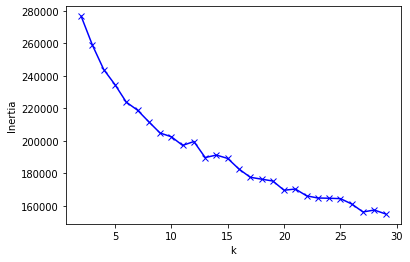

In [48]:
items, _ = vector_df.shape
Sum_of_squared_distances = []
K = range(2,np.min([30, items - 1]))
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(vector_df.to_numpy())
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

## Modelo 2: bag of chars
Extraer todos los grupos de caracteres del archivo y representarlos como un componente del vector de reprersentacion.
* Un grupo parar cada letra del alfabeto en inglés sensible a mayusculas. (52)
* Un grupo los diferentes digitos (10)
* Un grupo diferrente para comas, puntos, dos puntos, apostrofe y punto y coma (1)
* Un grupo que aglomere todos los caracteres especiales menos puntuación (1)
* Un grupo los caracterres de espacio (1)

In [50]:
upper_case = range(ord('A'), ord('Z') + 1)
lower_case = range(ord('a'), ord('z') + 1)
disgits = range(ord('0'), ord('9') + 1)

components = [ chr(n) for n in [ *disgits, *lower_case, *upper_case ]]
components += ['PUNCT', 'BLANK', 'SPECIAL']
components = pd.Series(components)
components

0           0
1           1
2           2
3           3
4           4
       ...   
60          Y
61          Z
62      PUNCT
63      BLANK
64    SPECIAL
Length: 65, dtype: object

In [51]:
alphanum_re = re.compile(r'[A-Za-z0-9]')
punct_re = re.compile(r'[\.,:;\'\"]')
blank_re = re.compile(r'\s+')
special_re = re.compile(r'[^A-Za-z0-9\s\.,:;\'"]')

def text_to_vector(text):
    vector = pd.Series(0, index=components)
    for c in alphanum_re.findall(text):
        vector[c] += 1

    vector['PUNCT'] = len( punct_re.findall(text) )
    vector['BLANK'] = len( blank_re.findall(text) )
    vector['SPECIAL'] = len( special_re.findall(text) )

    return vector

In [52]:
test = "sfsdfasdfsd@@¢#@.\t\t\t 342343 dfsdgfd ñæ∂∫©€ ardillasaurio, Y Z...'''\"\"\""
text_to_vector(test)

0           0
1           0
2           1
3           3
4           2
           ..
Y           1
Z           1
PUNCT      11
BLANK       6
SPECIAL    11
Length: 65, dtype: int64

In [54]:
model_2_df = entities.copy()
model_2_df['text'] = model_2_df.entitie.apply(lambda e: e.text)
model_2_df

,entitie,has_vector,text
0,"(﻿BioScience, Trends)",True,﻿BioScience Trends
1,(2020),True,2020
2,"(14(1):64, -, 68)",True,14(1):64-68
3,(10.5582),False,10.5582
4,(four),True,four
...,...,...,...
231344,"(MERS, -, CoV)",True,MERS-CoV
231345,"(the, 17, days, \n)",True,the 17 days\n
231346,"(patients7,8)",False,"patients7,8"
231347,(three),True,three


In [55]:
vector_df = model_2_df.text.apply(text_to_vector)
vector_df

,0,1,2,3,4,5,6,7,8,9,...,T,U,V,W,X,Y,Z,PUNCT,BLANK,SPECIAL
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,1
1,2,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,2,0,0,2,0,2,0,1,0,...,0,0,0,0,0,0,0,1,0,3
3,1,1,1,0,0,2,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231344,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
231345,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,3,0
231346,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
231347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


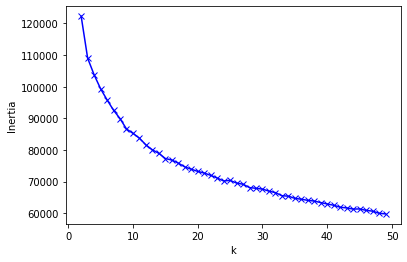

In [64]:
Sum_of_squared_distances = []
K = range(2,50)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(vector_df.to_numpy())
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

In [65]:
km = KMeans(n_clusters=4)
km = km.fit(vector_df.to_numpy())
model_2_df['km'] = km.labels_
model_2_df[['text', 'km']].to_csv('../Files/output/entitie_clasification_kmeans.csv')
model_2_df[['text', 'km']]

,text,km
0,﻿BioScience Trends,0
1,2020,1
2,14(1):64-68,1
3,10.5582,1
4,four,1
...,...,...
231344,MERS-CoV,1
231345,the 17 days\n,0
231346,"patients7,8",0
231347,three,0


In [68]:
model_2_df[ model_2_df.km == 0 ][['text']]

,text
0,﻿BioScience Trends
6,Chinese
7,Western
8,Xiaorong
10,Feifei Chen3
...,...
231324,three months
231336,Middle East
231345,the 17 days\n
231346,"patients7,8"
